In [1]:
# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import seaborn as sns

from pandas.io.json import json_normalize

In [2]:
#Definitions

today = pd.to_datetime('today').normalize()
current_eom = today + pd.offsets.MonthEnd(0)
start_date = "2017-01-01"
end_date = current_eom + pd.offsets.MonthEnd(11)
studio_debug = "London"
debug = True

def get_json(df):
    """ Small function to serialise DataFrame dates as 'YYYY-MM-DD' in JSON """

    def convert_timestamp(item_date_object):
        if isinstance(item_date_object, (datetime.date, datetime.datetime)):
            return item_date_object.strftime("%Y-%m-%d")
    
    dict_ = df.to_dict(orient="records")

    return json.dumps(dict_, default=convert_timestamp)

#display count and summary of any dataframe
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
pd.set_option('display.precision', 1)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

def difflist(li1, li2): 
    return (list(set(li1) - set(li2)))

def addlist(li1, li2): 
    return (li1.append(li2))

def remove_percetage(df, column_list):
    for col in column_list:
        df[col] = round(df[col].str.replace('%','').astype(np.float64) / 100, 4)
    return df

def coerce_df_columns_to_numeric(df):
    cols_float1 = list(df.filter(like='Rate', axis=1).columns)
    cols_float2 = list(df.filter(like='Yield', axis=1).columns)
    cols_float3 = list(df.filter(like='Diff%', axis=1).columns)
    cols_float4 = list(df.filter(like='Relative_Offset', axis=1).columns)
    cols_float5 = list(df.filter(like='sp500', axis=1).columns)
    cols_float6 = list(df.filter(like='Return', axis=1).columns)
    cols_float = cols_float1 + cols_float2 + cols_float3 + cols_float4 + cols_float5 + cols_float6
    #display("cols_float:", cols_float)
    cols_int1 = list(df.filter(like='Revenue', axis=1).columns)
    cols_int2 = list(df.filter(like='Conversions', axis=1).columns)
    cols_int3 = list(df.filter(like='Value', axis=1).columns)
    cols_int4 = list(df.filter(like='Pipeline', axis=1).columns)
    cols_int5 = list(df.filter(like='Offset', axis=1).columns)
    cols_int6 = list(df.filter(like='Headcount', axis=1).columns)
    cols_int = cols_int1 + cols_int2 + cols_int3 + cols_int4 + cols_int5 + cols_int6
    #display("cols_int:", cols_int)
    cols1 = list(df.select_dtypes(include='float64').columns)
    cols = cols1 + cols_int
    #display("cols:", cols)
    final_cols = difflist(cols,cols_float)
    #display("final_cols:", final_cols)
    df[final_cols] = df[final_cols].apply(pd.to_numeric, errors='coerce')
    df[final_cols] = df[final_cols].replace(np.nan, 0, regex=True)
    df[final_cols] = df[final_cols].astype(int)
    df[final_cols] = round(df[final_cols],0)
    #return df

def data_prep(df):
    df.columns = df.columns.astype(str).str.replace(" ", "_")
    if 'End_of_Month' in df.columns:
        df['End_of_Month'] = pd.to_datetime(df['End_of_Month']) #Format Date
    if 'Snapshot_Date_Short' in df.columns:
        df['Snapshot_Date_Short'] = pd.to_datetime(df['Snapshot_Date_Short']) #Format Date
    df = df.query('Studio not in @exclude_studio')
    df = df.replace(np.nan, 0, regex=True)
    return df

def show_stats(df):   
    print("\n DF Name: \n")
    display(get_df_name(df))
    print("\n DF Info: \n")
    display(df.info(verbose=True))
    print("\n DF Describe: \n")
    display(df.describe(include='all').transpose().head())
    print("\n DF Head: \n")
    display(df.head())
    print("\n DF Tail: \n")
    display(df.tail())
    group_by_studio = df.groupby(by=['Studio'], as_index=False)
    studio_sum = group_by_studio.sum().reset_index(drop=True)
    studio_count = group_by_studio.count().reset_index(drop=True)
    print("\n Studio Sum: \n")
    display(studio_sum.head())
    print("\n Studio Count: \n")
    display(studio_count.head())
    if 'End_of_Month' in df.columns:
        df['End_of_Month'] = pd.to_datetime(df['End_of_Month']) #Format Date
        group_by_eom = df.groupby(by=['End_of_Month'], as_index=False)
        eom_sum = group_by_eom.sum().reset_index(drop=True)
        eom_count = group_by_eom.count().reset_index(drop=True)
        print("\n EOM Sum:")
        display(eom_sum.head())
        print("\n EOM Count: \n")
        display(eom_count.head())
    if 'Snapshot_Date_Short' in df.columns:
        df['Snapshot_Date_Short'] = pd.to_datetime(df['Snapshot_Date_Short']) #Format Date
        group_by_sds = df.groupby(by=['Snapshot_Date_Short'], as_index=False)
        sds_sum = group_by_sds.sum().reset_index(drop=True)
        sds_count = group_by_sds.count().reset_index(drop=True)
        print("\n SDS Sum:")
        display(sds_sum.head())
        print("\n SDS Count: \n")
        display(sds_count.head())
    return

In [3]:
# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required
# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = 'db61fd47-db56-45e3-844f-1b1f5c47990a'
resource_group = 'BI-DevQA-RG'
workspace_name = 'dwmlazwu01'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='revtime_forecast')
dataset.to_pandas_dataframe()
df = dataset.to_pandas_dataframe()
df.columns = df.columns.astype(str).str.replace(" ", "_")
#df['Snapshot_Date_Short'] = pd.to_datetime(df['Snapshot_Date_Short'])
df = df.replace(np.nan, 0, regex=True)
show_stats(df)
#df.columns.name=None
df = df.reset_index(drop = True)

#df['End_of_Month'] = pd.to_datetime(df['End_of_Month'])
print("df :")
display(df.head())


 DF Name: 



'df'


 DF Info: 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 204 entries, 2020-08-31 to 2021-07-31
Data columns (total 18 columns):
End_of_Month                        204 non-null datetime64[ns]
Studio                              204 non-null object
Headcount                           204 non-null int64
Headcount_1M_Previous               204 non-null int64
Current_Opp._Period_Value           204 non-null int64
Opp_Period_Value_6M_Rolling_Sum     204 non-null int64
Opp_Period_Value_3M_Previous        204 non-null int64
Conversions                         204 non-null int64
Conversions_3_Month_Rolling_Avg     204 non-null int64
Conversions_3M_Rolling_Sum          204 non-null int64
Conversions_6M_Rolling_Sum          204 non-null int64
Conversions_12_Month_Rolling_Avg    204 non-null int64
Conversions_2M_Previous             204 non-null int64
Conversions_91_Days_Rolling_Avg     204 non-null int64
Conversions_182_Days_Rolling_Avg    204 non-null int64
sp500                       

None


 DF Describe: 



,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
End_of_Month,204,12,2021-04-30 00:00:00,17,2020-08-31 00:00:00,2021-07-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Studio,204,17,Chicago,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Headcount,204.00,NaN,NaN,NaN,NaN,NaN,39.23,24.60,1.00,23.00,36.00,55.00,86.00
Headcount_1M_Previous,204.00,NaN,NaN,NaN,NaN,NaN,39.23,24.58,1.00,23.00,36.00,55.00,86.00
Current_Opp._Period_Value,204.00,NaN,NaN,NaN,NaN,NaN,116525.89,666429.88,0.00,0.00,0.00,0.00,7067000.00



 DF Head: 



,End_of_Month,Studio,Headcount,Headcount_1M_Previous,Current_Opp._Period_Value,Opp_Period_Value_6M_Rolling_Sum,Opp_Period_Value_3M_Previous,Conversions,Conversions_3_Month_Rolling_Avg,Conversions_3M_Rolling_Sum,Conversions_6M_Rolling_Sum,Conversions_12_Month_Rolling_Avg,Conversions_2M_Previous,Conversions_91_Days_Rolling_Avg,Conversions_182_Days_Rolling_Avg,sp500,Monthly_Return,sp500_1M_Previous
2020-08-31,2020-08-31,Cambridge,46,45,4824000,21490705,4951960,512000,1262866,3788600,5747605,1314207,2300600,150000,150000,3508.01,0.07,3271.12
2020-08-31,2020-08-31,Chicago,85,85,825154,8233674,1050000,910098,1665067,4995202,16123293,2267936,3414590,473825,243512,3508.01,0.07,3271.12
2020-08-31,2020-08-31,Creative Leadership,3,3,0,307208,254520,35650,35425,70850,70850,39741,35200,0,0,3508.01,0.07,3271.12
2020-08-31,2020-08-31,D4C,32,33,255000,6481000,2000000,210000,442955,1328866,2431366,1015929,310000,0,40750,3508.01,0.07,3271.12
2020-08-31,2020-08-31,D4L,24,24,1250000,12555500,3425000,7500,318144,954434,2018434,510786,724950,0,550000,3508.01,0.07,3271.12



 DF Tail: 



,End_of_Month,Studio,Headcount,Headcount_1M_Previous,Current_Opp._Period_Value,Opp_Period_Value_6M_Rolling_Sum,Opp_Period_Value_3M_Previous,Conversions,Conversions_3_Month_Rolling_Avg,Conversions_3M_Rolling_Sum,Conversions_6M_Rolling_Sum,Conversions_12_Month_Rolling_Avg,Conversions_2M_Previous,Conversions_91_Days_Rolling_Avg,Conversions_182_Days_Rolling_Avg,sp500,Monthly_Return,sp500_1M_Previous
2021-07-31,2021-07-31,SF OS,55,55,0,0,0,0,0,0,0,0,0,0,0,3508.01,0.07,3271.12
2021-07-31,2021-07-31,Shanghai,38,38,0,0,0,0,0,0,0,917094,0,0,0,3508.01,0.07,3271.12
2021-07-31,2021-07-31,Super,85,85,0,0,0,0,0,0,0,810398,0,0,0,3508.01,0.07,3271.12
2021-07-31,2021-07-31,Teachers Guild,1,1,0,0,0,0,0,0,0,180288,0,0,0,3508.01,0.07,3271.12
2021-07-31,2021-07-31,Tokyo,36,36,0,0,0,0,0,0,0,1709158,0,0,0,3508.01,0.07,3271.12



 Studio Sum: 



,Studio,Headcount,Headcount_1M_Previous,Current_Opp._Period_Value,Opp_Period_Value_6M_Rolling_Sum,Opp_Period_Value_3M_Previous,Conversions,Conversions_3_Month_Rolling_Avg,Conversions_3M_Rolling_Sum,Conversions_6M_Rolling_Sum,Conversions_12_Month_Rolling_Avg,Conversions_2M_Previous,Conversions_91_Days_Rolling_Avg,Conversions_182_Days_Rolling_Avg,sp500,Monthly_Return,sp500_1M_Previous
0,Cambridge,563,561,4824000,74064569,13258560,512000,2518866,5788600,22918613,12437968,3788600,150000,600000,42096.12,0.87,39253.44
1,Chicago,1031,1030,825154,23278984,3792164,910098,3365471,7485912,35497689,22886689,4995202,661475,1463515,42096.12,0.87,39253.44
2,Creative Leadership,36,36,0,868936,254520,35650,106725,142150,354700,457014,70850,0,0,42096.12,0.87,39253.44
3,D4C,395,395,255000,19892000,4627000,210000,1162388,2557732,8420330,7015645,1328866,0,-57750,42096.12,0.87,39253.44
4,D4L,277,278,1250000,35430000,6243000,7500,440386,1191418,5782720,4469571,954434,0,550000,42096.12,0.87,39253.44



 Studio Count: 



,Studio,End_of_Month,Headcount,Headcount_1M_Previous,Current_Opp._Period_Value,Opp_Period_Value_6M_Rolling_Sum,Opp_Period_Value_3M_Previous,Conversions,Conversions_3_Month_Rolling_Avg,Conversions_3M_Rolling_Sum,Conversions_6M_Rolling_Sum,Conversions_12_Month_Rolling_Avg,Conversions_2M_Previous,Conversions_91_Days_Rolling_Avg,Conversions_182_Days_Rolling_Avg,sp500,Monthly_Return,sp500_1M_Previous
0,Cambridge,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12
1,Chicago,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12
2,Creative Leadership,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12
3,D4C,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12
4,D4L,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12



 EOM Sum:


,End_of_Month,Headcount,Headcount_1M_Previous,Current_Opp._Period_Value,Opp_Period_Value_6M_Rolling_Sum,Opp_Period_Value_3M_Previous,Conversions,Conversions_3_Month_Rolling_Avg,Conversions_3M_Rolling_Sum,Conversions_6M_Rolling_Sum,Conversions_12_Month_Rolling_Avg,Conversions_2M_Previous,Conversions_91_Days_Rolling_Avg,Conversions_182_Days_Rolling_Avg,sp500,Monthly_Return,sp500_1M_Previous
0,2020-08-31,666,667,23771282,162803948,29847733,9084647,12116540,31075858,74992774,13626225,10187745,1822873,4453923,59636.17,1.23,55609.04
1,2020-09-30,667,666,0,130159629,23928794,0,11699897,20888113,50658188,13508322,11823466,1253298,2075973,59636.17,1.23,55609.04
2,2020-10-31,667,667,0,95921487,18373675,0,9064647,9064647,40454417,13889065,9064647,325648,1664064,59636.17,1.23,55609.04
3,2020-11-30,667,667,0,66073753,23771282,0,0,0,31075858,13452376,0,0,1822873,59636.17,1.23,55609.04
4,2020-12-31,667,667,0,42144959,0,0,0,0,20888113,13951012,0,0,1253298,59636.17,1.23,55609.04



 EOM Count: 



,End_of_Month,Studio,Headcount,Headcount_1M_Previous,Current_Opp._Period_Value,Opp_Period_Value_6M_Rolling_Sum,Opp_Period_Value_3M_Previous,Conversions,Conversions_3_Month_Rolling_Avg,Conversions_3M_Rolling_Sum,Conversions_6M_Rolling_Sum,Conversions_12_Month_Rolling_Avg,Conversions_2M_Previous,Conversions_91_Days_Rolling_Avg,Conversions_182_Days_Rolling_Avg,sp500,Monthly_Return,sp500_1M_Previous
0,2020-08-31,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
1,2020-09-30,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
2,2020-10-31,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
3,2020-11-30,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
4,2020-12-31,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17


df :


,End_of_Month,Studio,Headcount,Headcount_1M_Previous,Current_Opp._Period_Value,Opp_Period_Value_6M_Rolling_Sum,Opp_Period_Value_3M_Previous,Conversions,Conversions_3_Month_Rolling_Avg,Conversions_3M_Rolling_Sum,Conversions_6M_Rolling_Sum,Conversions_12_Month_Rolling_Avg,Conversions_2M_Previous,Conversions_91_Days_Rolling_Avg,Conversions_182_Days_Rolling_Avg,sp500,Monthly_Return,sp500_1M_Previous
0,2020-08-31,Cambridge,46,45,4824000,21490705,4951960,512000,1262866,3788600,5747605,1314207,2300600,150000,150000,3508.01,0.07,3271.12
1,2020-08-31,Chicago,85,85,825154,8233674,1050000,910098,1665067,4995202,16123293,2267936,3414590,473825,243512,3508.01,0.07,3271.12
2,2020-08-31,Creative Leadership,3,3,0,307208,254520,35650,35425,70850,70850,39741,35200,0,0,3508.01,0.07,3271.12
3,2020-08-31,D4C,32,33,255000,6481000,2000000,210000,442955,1328866,2431366,1015929,310000,0,40750,3508.01,0.07,3271.12
4,2020-08-31,D4L,24,24,1250000,12555500,3425000,7500,318144,954434,2018434,510786,724950,0,550000,3508.01,0.07,3271.12


In [4]:
#pivot
#df_pivot = df.pivot_table(index='End_of_Month', columns='Studio', value = 'Revenue', aggfunc=np.sum, margins=False)
#df3_pivot1['EOM1'] = pd.to_datetime(df3_pivot1['End_of_Month']).dt.date.astype(str)
#df_pivot.columns.name=None
#df_pivot = df_pivot.reset_index()
#df_pivot = df_pivot.reset_index(level=df_pivot.index.names)
#df_pivot

In [5]:
#Limit for forecast horizon
revtime = df.copy()
forecast_horizon = 6 #months
#today = datetime.date.today()
#today_plus_month_offset = today + pd.offsets.MonthEnd(6)
#lt_plus_month_offset = pd.to_datetime(df1['End of Month']) <= today_plus_month_offset
#forecast_horizon1 = revtime['Relative_Month_Offset'] < forecast_horizon
revtime['Relative_Month_Offset'] = round((revtime['End_of_Month'] - current_eom)/np.timedelta64(1,'M'),0)
revtime = revtime.query('Relative_Month_Offset < @forecast_horizon')
revtime

,End_of_Month,Studio,Headcount,Headcount_1M_Previous,Current_Opp._Period_Value,Opp_Period_Value_6M_Rolling_Sum,Opp_Period_Value_3M_Previous,Conversions,Conversions_3_Month_Rolling_Avg,Conversions_3M_Rolling_Sum,Conversions_6M_Rolling_Sum,Conversions_12_Month_Rolling_Avg,Conversions_2M_Previous,Conversions_91_Days_Rolling_Avg,Conversions_182_Days_Rolling_Avg,sp500,Monthly_Return,sp500_1M_Previous,Relative_Month_Offset
0,2020-08-31,Cambridge,46,45,4824000,21490705,4951960,512000,1262866,3788600,5747605,1314207,2300600,150000,150000,3508.01,0.07,3271.12,-1.00
1,2020-08-31,Chicago,85,85,825154,8233674,1050000,910098,1665067,4995202,16123293,2267936,3414590,473825,243512,3508.01,0.07,3271.12,-1.00
2,2020-08-31,Creative Leadership,3,3,0,307208,254520,35650,35425,70850,70850,39741,35200,0,0,3508.01,0.07,3271.12,-1.00
3,2020-08-31,D4C,32,33,255000,6481000,2000000,210000,442955,1328866,2431366,1015929,310000,0,40750,3508.01,0.07,3271.12,-1.00
4,2020-08-31,D4L,24,24,1250000,12555500,3425000,7500,318144,954434,2018434,510786,724950,0,550000,3508.01,0.07,3271.12,-1.00
5,2020-08-31,Food,23,23,1275000,4345000,810000,0,85000,255000,255000,472460,150000,125000,125000,3508.01,0.07,3271.12,-1.00
6,2020-08-31,Global,72,71,0,10220803,2199500,362502,371967,1115902,6115417,849468,45080,0,1351500,3508.01,0.07,3271.12,-1.00
7,2020-08-31,Health,24,26,2230000,18235400,4465000,2515000,1926700,3853400,10724225,1325961,0,485000,462500,3508.01,0.07,3271.12,-1.00
8,2020-08-31,London,55,55,692337,6794964,930825,0,480121,960243,1198699,676401,142691,0,0,3508.01,0.07,3271.12,-1.00
9,2020-08-31,Munich,38,39,572550,10403955,1249820,561099,474992,949984,1001403,521303,388885,0,0,3508.01,0.07,3271.12,-1.00


In [6]:
import datetime
from dateutil.tz import tzutc

from pandas.io.json import json_normalize

In [7]:
#data = revenueforecastdf.to_json(orient="records")
# Convert to JSON string
import numpy as np

def get_json(df):
    """ Small function to serialise DataFrame dates as 'YYYY-MM-DD' in JSON """

    def convert_timestamp(item_date_object):
        if isinstance(item_date_object, (datetime.date, datetime.datetime)):
            return item_date_object.strftime("%Y-%m-%d")
    
    dict_ = df.to_dict(orient="records")

    return json.dumps(dict_, default=convert_timestamp)

#df1 = df.replace(np.nan, 0, regex=True)

input_data = get_json(revtime)
#data_loads = json.loads(input_data)
#data_loads['data']
print("Input Data: ",type(input_data))
input_data = "{\"data\" :" + input_data + "}"
input_data[0:2000]

Input Data:  <class 'str'>


'{"data" :[{"End_of_Month": "2020-08-31", "Studio": "Cambridge", "Headcount": 46, "Headcount_1M_Previous": 45, "Current_Opp._Period_Value": 4824000, "Opp_Period_Value_6M_Rolling_Sum": 21490705, "Opp_Period_Value_3M_Previous": 4951960, "Conversions": 512000, "Conversions_3_Month_Rolling_Avg": 1262866, "Conversions_3M_Rolling_Sum": 3788600, "Conversions_6M_Rolling_Sum": 5747605, "Conversions_12_Month_Rolling_Avg": 1314207, "Conversions_2M_Previous": 2300600, "Conversions_91_Days_Rolling_Avg": 150000, "Conversions_182_Days_Rolling_Avg": 150000, "sp500": 3508.01, "Monthly_Return": 0.07241862114505127, "sp500_1M_Previous": 3271.12, "Relative_Month_Offset": -1.0}, {"End_of_Month": "2020-08-31", "Studio": "Chicago", "Headcount": 85, "Headcount_1M_Previous": 85, "Current_Opp._Period_Value": 825154, "Opp_Period_Value_6M_Rolling_Sum": 8233674, "Opp_Period_Value_3M_Previous": 1050000, "Conversions": 910098, "Conversions_3_Month_Rolling_Avg": 1665067, "Conversions_3M_Rolling_Sum": 4995202, "Conver

In [8]:
# URL for the web service
scoring_uri = 'http://be8aa3e6-152b-4f1e-931b-f3803dc5b27a.westus2.azurecontainer.io/score'
# If the service is authenticated, set the key or token
key = '8oWmn73o8OyRBL6nUFgTVtcW833hfEEC'

# Set the content type
headers = {'Content-Type': 'application/json'}
# If authentication is enabled, set the authorization header
headers['Authorization'] = f'Bearer {key}'

In [9]:
# Make the request and display the response
#while True:
#    try:
resp = requests.post(scoring_uri, input_data, headers=headers)
json_data = resp.text
print("Json Data:", type(json_data))
json_data[0:2000]
#   except Exception as e:
#        result = str(e)
#        print(json.dumps({"error": result}))
#df_rest = pd.DataFrame.from_records(resp.json())
#df_rest

Json Data: <class 'str'>


'"{\\"forecast\\": [1072284.8071953836, 1565124.822497664, 37727.03539782199, 876182.7711434602, 490595.625344182, 444271.902009542, 153764.71280121783, 709341.9694556328, 879246.6485979273, 477891.4421795879, 439522.8130271296, 212293.04119306855, 294373.76786168414, 604436.3210829415, 2475863.16584895, 66446.73047764483, 547168.7210884134, 877072.0715354722, 1496169.754825054, 18966.059222839704, 866525.5058569338, 443219.97886108444, 435596.694802564, 179030.63157380166, 715432.5270398078, 942536.5920051818, 479160.82681019406, 441973.17438182194, 210819.0524031532, 280723.55241751944, 492255.7466021371, 2510786.253594637, 60043.49192635207, 535350.9398656047, 892459.5398884135, 1546906.6268847932, 29703.82058712466, 886146.8664539459, 437284.17870825133, 441239.5490378763, 182755.34874618094, 639033.4480253345, 909970.9399309688, 483109.3468476111, 441477.75465886865, 218338.24370981683, 278558.22513078153, 519880.12390596094, 2502775.817500364, 59060.827482010965, 613474.817070714

In [10]:
#Convert response to python dictionary
import datetime
from dateutil.tz import tzutc

r_json = resp.json()
r_json_loads = json.loads(r_json)
type(r_json_loads)
print("Data Dict Type=", type(r_json_loads))
print("Data Dict Keys=",r_json_loads.keys())
data_dict = r_json_loads
#data_dict['forecast']
#for i in data_dict:
#    if isinstance(i, dict):
#        for key, value in i.items():
#            print(key, value)
#    else:
#        print(i)
        
#for key, value in data_dict.items():
#        print(key, ":", value)

Data Dict Type= <class 'dict'>
Data Dict Keys= dict_keys(['forecast', 'index'])


In [11]:
#Convert response to python dictionary
#import datetime
#from dateutil.tz import tzutc

#loaded_json = json.loads(json_data)

#print("Loaded Json=",type(loaded_json))
#norm_json = json_normalize(loaded_json)
#print(norm_json)

#print(json.dumps(loaded_json, indent=4, sort_keys=True))

#data_dict = json.loads(loaded_json)
#print("Data Dict Type=", type(data_dict))
#print("Data Dict Keys=",data_dict.keys())
#data_dict['forecast'][0]
#json_normalize(data_dict)
#json_normalize(data_dict, record_path='index')
#df1 = pd.DataFrame.from_dict(json_normalize(data_dict))
#df1['index']=[df1['index']]
#json_normalize(data_dict['index'])



In [12]:
print("Convert Nested Data Dictornary to flattened Dataframe and datetime to date format")
####Convert Nested Data Dictornary to flattened Dataframe
df1 = pd.DataFrame(data_dict)
df2 = pd.DataFrame()
for col in reversed(df1.columns):
    display(col)
    norm = json_normalize(data_dict, record_path=col).add_prefix(f'{col}.')
    df2= pd.concat([df2, norm], axis=1, sort=False)
    df2.columns = df2.columns.astype(str).str.replace("index.", "")
    df2.columns = df2.columns.astype(str).str.replace(".0", "")
    df2.columns = df2.columns.astype(str).str.replace(" ", "_")
df2['forecast'] = round(df2["forecast"],0)
df2['End_of_Month'] = pd.to_datetime(df2['End_of_Month'], unit='ms')
df2['End_of_Month'] = pd.to_datetime(df2['End_of_Month'])
coerce_df_columns_to_numeric(df2)
#df2['EOM1'] = pd.to_datetime(df2['End_of_Month']).dt.date.astype(str)
df2 = df2.reset_index(drop=True)
#df2['Forecast'] = round(df2['0'],0)
#df2.drop(columns=['0'], axis=1, inplace = True)
#show_stats(df2)
df2

Convert Nested Data Dictornary to flattened Dataframe and datetime to date format


'index'

'forecast'

,End_of_Month,Studio,origin,forecast
0,2020-08-31,Cambridge,1596153600000,1072285
1,2020-08-31,Chicago,1596153600000,1565125
2,2020-08-31,Creative Leadership,1596153600000,37727
3,2020-08-31,D4C,1596153600000,876183
4,2020-08-31,D4L,1596153600000,490596
5,2020-08-31,Food,1596153600000,444272
6,2020-08-31,Global,1596153600000,153765
7,2020-08-31,Health,1596153600000,709342
8,2020-08-31,London,1596153600000,879247
9,2020-08-31,Munich,1596153600000,477891


In [13]:
#Concatenate Forecast RESULTS with revpipe_final dataframe
revtime_hist1 = pd.read_csv("revtime_hist.csv")
revtime_hist2 = revtime_hist1.append(df2, ignore_index=True, sort=True)
revtime_hist2 = revtime_hist2.replace(np.nan, 0, regex=True)
#revtime1 = pd.concat([revtime1, df2], axis=1, sort=False)
revtime_hist2['Revenue_Forecast'] = revtime_hist2['Revenue'] + revtime_hist2['forecast']
revtime_hist2['End_of_Month'] = pd.to_datetime(revtime_hist2['End_of_Month'])
revtime_hist2 = revtime_hist2.reset_index(drop=True)
coerce_df_columns_to_numeric(revtime_hist2)
print("revtime_hist2 info:")
show_stats(revtime_hist2)
revtime_hist2.to_csv("revtime_hist2.csv", index=False)
revtime_hist2.query('Studio==@studio_debug')

revtime_hist2 info:

 DF Name: 



'revtime_hist2'


 DF Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 22 columns):
Conversions                         850 non-null int64
Conversions_12_Month_Rolling_Avg    850 non-null int64
Conversions_182_Days_Rolling_Avg    850 non-null int64
Conversions_2M_Previous             850 non-null int64
Conversions_3M_Rolling_Sum          850 non-null int64
Conversions_3_Month_Rolling_Avg     850 non-null int64
Conversions_6M_Rolling_Sum          850 non-null int64
Conversions_91_Days_Rolling_Avg     850 non-null int64
Current_Opp._Period_Value           850 non-null int64
End_of_Month                        850 non-null datetime64[ns]
Headcount                           850 non-null int64
Headcount_1M_Previous               850 non-null int64
Monthly_Return                      850 non-null float64
Opp_Period_Value_3M_Previous        850 non-null int64
Opp_Period_Value_6M_Rolling_Sum     850 non-null int64
Revenue                             850 non-nu

None


 DF Describe: 



,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Conversions,850.00,NaN,NaN,NaN,NaN,NaN,532094.53,980335.16,0.00,0.00,65628.00,681193.00,10141851.00
Conversions_12_Month_Rolling_Avg,850.00,NaN,NaN,NaN,NaN,NaN,559299.46,555804.81,0.00,782.00,510348.50,818229.75,2655813.00
Conversions_182_Days_Rolling_Avg,850.00,NaN,NaN,NaN,NaN,NaN,126390.48,373718.17,-485000.00,0.00,0.00,60000.00,3220000.00
Conversions_2M_Previous,850.00,NaN,NaN,NaN,NaN,NaN,517716.47,971504.57,-1400000.00,0.00,64000.50,675000.00,10141851.00
Conversions_3M_Rolling_Sum,850.00,NaN,NaN,NaN,NaN,NaN,1564569.67,2127662.81,-825501.00,0.00,794990.50,2245979.75,13136906.00



 DF Head: 



,Conversions,Conversions_12_Month_Rolling_Avg,Conversions_182_Days_Rolling_Avg,Conversions_2M_Previous,Conversions_3M_Rolling_Sum,Conversions_3_Month_Rolling_Avg,Conversions_6M_Rolling_Sum,Conversions_91_Days_Rolling_Avg,Current_Opp._Period_Value,End_of_Month,Headcount,Headcount_1M_Previous,Monthly_Return,Opp_Period_Value_3M_Previous,Opp_Period_Value_6M_Rolling_Sum,Revenue,Studio,forecast,origin,sp500,sp500_1M_Previous,Revenue_Forecast
0,2985008,1382454,50559,611950,5074359,1691453,8121901,99999,0,2017-01-31,50,0,0.02,0,0,1384053,Cambridge,0,0,2278.87,2238.83,1384053
1,160350,1133988,137350,1395276,2055627,685209,4669382,0,0,2017-01-31,50,49,0.02,0,0,1236187,Chicago,0,0,2278.87,2238.83,1236187
2,0,0,0,0,0,0,0,0,0,2017-01-31,0,0,0.02,0,0,0,Creative Leadership,0,0,2278.87,2238.83,0
3,1475000,970818,50000,240000,2259000,753000,4811000,0,0,2017-01-31,34,0,0.02,0,0,1140432,D4C,0,0,2278.87,2238.83,1140432
4,1500000,819235,0,618000,2517500,839166,4490123,0,0,2017-01-31,21,0,0.02,0,0,601459,D4L,0,0,2278.87,2238.83,601459



 DF Tail: 



,Conversions,Conversions_12_Month_Rolling_Avg,Conversions_182_Days_Rolling_Avg,Conversions_2M_Previous,Conversions_3M_Rolling_Sum,Conversions_3_Month_Rolling_Avg,Conversions_6M_Rolling_Sum,Conversions_91_Days_Rolling_Avg,Current_Opp._Period_Value,End_of_Month,Headcount,Headcount_1M_Previous,Monthly_Return,Opp_Period_Value_3M_Previous,Opp_Period_Value_6M_Rolling_Sum,Revenue,Studio,forecast,origin,sp500,sp500_1M_Previous,Revenue_Forecast
845,0,0,0,0,0,0,0,0,0,2021-02-28,0,0,0.00,0,0,0,SF OS,305579,1612051200000,0.00,0.00,305579
846,0,0,0,0,0,0,0,0,0,2021-02-28,0,0,0.00,0,0,0,Shanghai,452323,1612051200000,0.00,0.00,452323
847,0,0,0,0,0,0,0,0,0,2021-02-28,0,0,0.00,0,0,0,Super,2503496,1612051200000,0.00,0.00,2503496
848,0,0,0,0,0,0,0,0,0,2021-02-28,0,0,0.00,0,0,0,Teachers Guild,37925,1612051200000,0.00,0.00,37925
849,0,0,0,0,0,0,0,0,0,2021-02-28,0,0,0.00,0,0,0,Tokyo,482950,1612051200000,0.00,0.00,482950



 Studio Sum: 



,Studio,Conversions,Conversions_12_Month_Rolling_Avg,Conversions_182_Days_Rolling_Avg,Conversions_2M_Previous,Conversions_3M_Rolling_Sum,Conversions_3_Month_Rolling_Avg,Conversions_6M_Rolling_Sum,Conversions_91_Days_Rolling_Avg,Current_Opp._Period_Value,Headcount,Headcount_1M_Previous,Monthly_Return,Opp_Period_Value_3M_Previous,Opp_Period_Value_6M_Rolling_Sum,Revenue,forecast,origin,sp500,sp500_1M_Previous,Revenue_Forecast
0,Cambridge,44661871,43926935,7859816,43474622,133299765,44433243,264128042,6381496,98765850,2036,1991,0.43,97480287,583219516,53083630,6418049,11188972800000,118791.17,117758.88,59501679
1,Chicago,75062928,68697264,6155447,72873101,222828444,75061232,432129431,4512469,111521601,3077,3041,0.43,120638648,711221831,71538930,10597215,11188972800000,118791.17,117758.88,82136145
2,Creative Leadership,218774,567401,0,183574,621122,485284,1171844,0,833591,51,48,0.43,579071,4132610,705137,158982,11188972800000,118791.17,117758.88,864119
3,D4C,58090320,56814373,2772569,56220469,169066273,56355412,342885680,3021310,71878318,1610,1577,0.43,69921050,424981568,45457332,6015211,11188972800000,118791.17,117758.88,51472543
4,D4L,23568342,28412401,25129000,23243908,69768108,26577553,141618455,12621000,37990500,966,942,0.43,34689875,208474875,27985056,3172405,11188972800000,118791.17,117758.88,31157461



 Studio Count: 



,Studio,Conversions,Conversions_12_Month_Rolling_Avg,Conversions_182_Days_Rolling_Avg,Conversions_2M_Previous,Conversions_3M_Rolling_Sum,Conversions_3_Month_Rolling_Avg,Conversions_6M_Rolling_Sum,Conversions_91_Days_Rolling_Avg,Current_Opp._Period_Value,End_of_Month,Headcount,Headcount_1M_Previous,Monthly_Return,Opp_Period_Value_3M_Previous,Opp_Period_Value_6M_Rolling_Sum,Revenue,forecast,origin,sp500,sp500_1M_Previous,Revenue_Forecast
0,Cambridge,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50
1,Chicago,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50
2,Creative Leadership,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50
3,D4C,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50
4,D4L,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50



 EOM Sum:


,End_of_Month,Conversions,Conversions_12_Month_Rolling_Avg,Conversions_182_Days_Rolling_Avg,Conversions_2M_Previous,Conversions_3M_Rolling_Sum,Conversions_3_Month_Rolling_Avg,Conversions_6M_Rolling_Sum,Conversions_91_Days_Rolling_Avg,Current_Opp._Period_Value,Headcount,Headcount_1M_Previous,Monthly_Return,Opp_Period_Value_3M_Previous,Opp_Period_Value_6M_Rolling_Sum,Revenue,forecast,origin,sp500,sp500_1M_Previous,Revenue_Forecast
0,2017-01-31,10541476,9356850,652960,7712003,25321270,8935241,47380016,99999,0,501,307,0.30,0,0,9335153,0,0,38740.79,38060.11,9335153
1,2017-02-28,7357435,8916074,652960,7067789,24966702,8337217,46612069,99999,0,503,501,0.63,0,0,9173656,0,0,40181.88,38740.79,9173656
2,2017-03-31,8864803,8995457,652960,10541476,26763715,9502255,47841825,99999,0,508,503,-0.01,0,0,11264470,0,0,40166.24,40181.88,11264470
3,2017-04-30,5176597,8226856,652960,7357435,21398837,8294519,46720108,149999,0,506,508,0.15,0,0,9544445,0,0,40531.40,40166.24,9544445
4,2017-05-31,6739961,7935602,149999,8864803,20781361,8673360,45748065,50000,0,510,506,0.20,0,0,10408480,0,0,41000.60,40531.40,10408480



 EOM Count: 



,End_of_Month,Conversions,Conversions_12_Month_Rolling_Avg,Conversions_182_Days_Rolling_Avg,Conversions_2M_Previous,Conversions_3M_Rolling_Sum,Conversions_3_Month_Rolling_Avg,Conversions_6M_Rolling_Sum,Conversions_91_Days_Rolling_Avg,Current_Opp._Period_Value,Headcount,Headcount_1M_Previous,Monthly_Return,Opp_Period_Value_3M_Previous,Opp_Period_Value_6M_Rolling_Sum,Revenue,Studio,forecast,origin,sp500,sp500_1M_Previous,Revenue_Forecast
0,2017-01-31,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
1,2017-02-28,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
2,2017-03-31,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
3,2017-04-30,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
4,2017-05-31,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17


,Conversions,Conversions_12_Month_Rolling_Avg,Conversions_182_Days_Rolling_Avg,Conversions_2M_Previous,Conversions_3M_Rolling_Sum,Conversions_3_Month_Rolling_Avg,Conversions_6M_Rolling_Sum,Conversions_91_Days_Rolling_Avg,Current_Opp._Period_Value,End_of_Month,Headcount,Headcount_1M_Previous,Monthly_Return,Opp_Period_Value_3M_Previous,Opp_Period_Value_6M_Rolling_Sum,Revenue,Studio,forecast,origin,sp500,sp500_1M_Previous,Revenue_Forecast
8,912449,597650,39226,1448498,2418664,806221,3564730,0,0,2017-01-31,42,37,0.02,0,0,640653,London,0,0,2278.87,2238.83,640653
25,293644,546714,39226,57716,1263810,421270,3454786,0,0,2017-02-28,43,42,0.04,0,0,686520,London,0,0,2363.64,2278.87,686520
42,484583,496340,39226,912449,1690677,563559,3646614,0,0,2017-03-31,42,43,-0.00,0,0,695914,London,0,0,2362.72,2363.64,695914
59,0,509559,39226,293644,778228,389114,3196892,0,0,2017-04-30,42,42,0.01,0,0,620690,London,0,0,2384.20,2362.72,620690
76,255102,517937,0,484583,739685,369842,2003496,0,0,2017-05-31,43,42,0.01,0,0,480997,London,0,0,2411.80,2384.20,480997
93,958208,543765,0,0,1213310,606655,2903988,0,0,2017-06-30,44,43,0.00,0,0,613119,London,0,0,2423.41,2411.80,613119
110,4920,505562,4920,255102,1218230,406076,1996459,4920,0,2017-07-31,45,44,0.02,0,0,924330,London,0,0,2470.30,2423.41,924330
127,1677150,621341,4920,958208,2640279,880093,3379965,4920,0,2017-08-31,44,45,0.00,0,0,652908,London,0,0,2471.65,2470.30,652908
144,335803,625254,4920,4920,2017874,672624,3231185,4920,0,2017-09-30,45,44,0.02,0,0,906711,London,0,0,2519.36,2471.65,906711
161,353710,616526,4920,1677150,2366664,788888,3584895,0,0,2017-10-31,44,45,0.02,0,0,813818,London,0,0,2575.26,2519.36,813818


In [14]:
#pivot by Studio, End_of_Month
revtime_hist3 = revtime_hist2.copy()
revtime_hist3['End_of_Month'] = pd.to_datetime(revtime_hist3['End_of_Month'])
revtime_hist3['EOM1'] = pd.to_datetime(revtime_hist3['End_of_Month']).dt.date.astype(str)
revtime_hist3['Relative_Month_Offset'] = round((revtime_hist3['End_of_Month'] - current_eom)/np.timedelta64(1,'M'),0)
revtime_pivot = revtime_hist3.pivot_table(index=['Studio'], columns='EOM1', values='Revenue_Forecast', aggfunc=np.sum, margins=True)
revtime_pivot = revtime_pivot.reset_index(level=revtime_pivot.index.names)
print("revtime_pivot info:")
#show_stats(revtime_pivot)
revtime_pivot
#revtime_pivot.to_csv("revtime_pivot.csv", index=False)

revtime_pivot info:


EOM1,Studio,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,All
0,Cambridge,1384053,1332710,1357529,1357472,951107,975758,1015603,1411213,1250017,1017263,1191312,958254,1266596,915739,1008161,1230593,1340495,1326759,1167320,1615715,1223964,1474613,1219103,931666,1252541,1414292,1485930,1391929,1626982,1048382,807218,1153362,1227437,1589011,1197871,1343337,1448453,1570966,1209622,778768,746372,1528960,1339182,1072285,877072,892460,877236,887207,884569,927220,59501679
1,Chicago,1236187,1174753,1348348,876946,1026152,971551,836589,1514153,1466961,1560123,1608590,1690583,2007709,1877264,1691420,1983630,2124333,1923945,1471901,2311118,2002735,1877350,1494602,1880015,2251215,1701750,1697617,1711898,2032551,1632468,1838973,1892245,1742905,2253953,1514703,1436107,1874354,1749110,2180073,1539868,1455175,1046204,2030803,1565125,1496170,1546907,1458134,1499613,1523628,1507638,82136145
2,Creative Leadership,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39755,0,30836,67184,64070,28378,38869,43117,61958,28789,62290,38292,75935,0,54442,27988,0,20800,22434,37727,18966,29704,19807,19981,19743,13054,864119
3,D4C,1140432,1009751,1261355,1063834,1012528,632072,658089,861588,865855,815898,784046,582971,720970,986171,972132,966847,1407222,1493737,1355137,1126195,998130,1139782,1226198,842861,732754,1147662,1335209,1216473,1211769,1228093,1211228,1147603,1292017,1435729,1273163,1229724,1133353,929016,1262846,998295,897727,994653,856217,876183,866526,886147,872587,883238,903757,726773,51472543
4,D4L,601459,588251,715256,708784,775361,607252,827090,868164,772899,697165,563553,521577,809571,511336,693993,472836,607663,604920,526425,640650,791091,756216,538323,628613,673082,874405,599775,552530,659160,481779,475141,633716,891731,729341,674850,644062,733816,740619,630345,509673,376142,547541,728900,490596,443220,437284,416287,435543,485154,464321,31157461
5,Food,365722,469015,628174,502825,779797,824479,244393,471425,407874,629599,553589,381319,562948,451289,689905,604582,790969,725477,446128,685434,518134,1070926,609125,513832,625342,590129,878167,775761,493507,677435,966894,823861,727755,641674,605931,688928,736211,614440,657949,341400,209995,455535,567559,444272,435597,441240,434189,443324,481580,461755,29147390
6,Global,54366,25235,102164,26579,380818,0,94461,215733,102421,107992,88475,0,75915,0,0,542437,0,124917,489498,143473,112534,0,410265,7041,190044,0,0,0,0,0,10134,0,29609,0,214851,513784,133238,203137,272478,123053,75484,203363,404772,153765,179031,182755,198389,198877,192490,223062,6806640
7,Health,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,489339,431680,516490,741413,613258,448615,590956,467906,403751,621287,946333,667299,793421,709342,715433,639033,472215,477962,539267,536680,11821680
8,London,640653,686520,695914,620690,480997,613119,924330,652908,906711,813818,853997,569694,567708,594053,790359,965867,1104504,943727,1078885,911414,783017,975430,776039,773985,818923,933761,1226119,1086902,1242626,1432126,1442979,842942,1103362,1556990,1655267,1172106,1147846,875646,1246211,1001446,1026564,899121,1073541,879247,942537,909971,915196,919625,922178,922095,46919666
9,Munich,515289,484995,652723,674009,690926,604594,403545,497959,536501,574534,576018,426700,625712,259676,923017,876747,745713,672629,565461,430848,715636,771263,793417,472400,506888,547094,669188,841655,1070382,452087,692271,376489,561654,582398,817445,535550,719589,827409,850207,396417,341350,430169,328536,477891,479161,483109,439131,441134,451291,437083,29245890


In [15]:
#pivot by EOM1, Studio
revtime_pivot1 = revtime_hist3.pivot_table(index='End_of_Month', columns='Studio', values='Revenue_Forecast', aggfunc=np.sum, margins=True)
revtime_pivot1 = revtime_pivot1.reset_index(level=revtime_pivot1.index.names)
#show_stats(revtime_pivot1)
revtime_pivot1

Studio,End_of_Month,Cambridge,Chicago,Creative Leadership,D4C,D4L,Food,Global,Health,London,Munich,New York,OpenIDEO,SF OS,Shanghai,Super,Teachers Guild,Tokyo,All
0,2017-01-31 00:00:00,1384053,1236187,0,1140432,601459,365722,54366,0,640653,515289,867989,317276,238538,639967,1003829,0,329393,9335153
1,2017-02-28 00:00:00,1332710,1174753,0,1009751,588251,469015,25235,0,686520,484995,1174616,165442,90335,626792,994054,3254,347933,9173656
2,2017-03-31 00:00:00,1357529,1348348,0,1261355,715256,628174,102164,0,695914,652723,1371350,185165,256337,787987,1368600,151141,382427,11264470
3,2017-04-30 00:00:00,1357472,876946,0,1063834,708784,502825,26579,0,620690,674009,1072049,135744,172774,903022,984660,49895,395162,9544445
4,2017-05-31 00:00:00,951107,1026152,0,1012528,775361,779797,380818,0,480997,690926,1405048,202905,273546,719566,1306511,25506,377712,10408480
5,2017-06-30 00:00:00,975758,971551,0,632072,607252,824479,0,0,613119,604594,1346030,295706,191964,791621,1624927,45357,378366,9902796
6,2017-07-31 00:00:00,1015603,836589,0,658089,827090,244393,94461,0,924330,403545,824111,229056,163257,581189,1167067,29149,405259,8403188
7,2017-08-31 00:00:00,1411213,1514153,0,861588,868164,471425,215733,0,652908,497959,651448,265949,225787,730547,981323,80466,442962,9871625
8,2017-09-30 00:00:00,1250017,1466961,0,865855,772899,407874,102421,0,906711,536501,763474,198166,160782,673848,986139,58040,491872,9641560
9,2017-10-31 00:00:00,1017263,1560123,0,815898,697165,629599,107992,0,813818,574534,455797,282150,253578,432792,1026666,59736,458260,9185371


In [16]:
# multiple line plot
#Set themes
import matplotlib.pyplot as plt
#plot
sns.set()
sns.set_context("poster") #In order of relative size they are: paper, notebook, talk, and poster. Notebook is default
sns.set(style="whitegrid") #Seaborn has five built-in themes to style its plots: darkgrid, whitegrid, dark, white, and ticks. 
# Save a palette to a variable:
palette = sns.color_palette("Accent",8)
# Use palplot and pass in the variable:
#sns.palplot(palette)
# Set the palette using the name of a palette:
#sns.set_palette(palette)

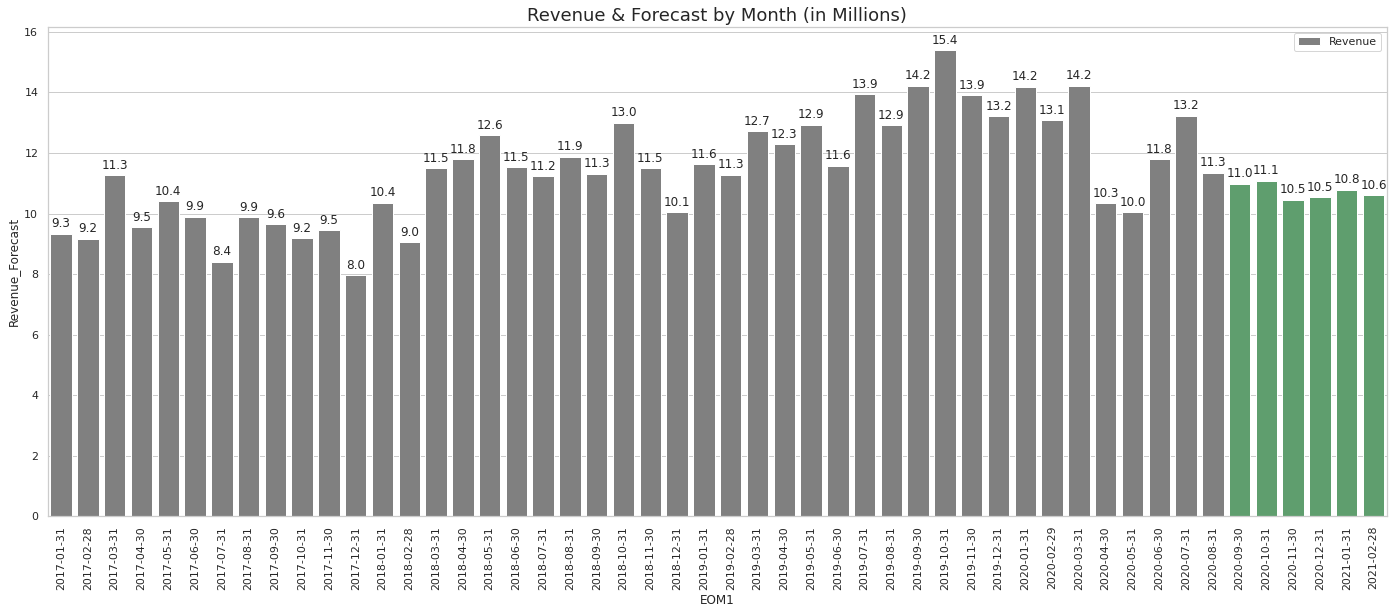

In [17]:
fig, ax = plt.subplots(figsize=(24,9))
div_by_thousand = 1000
div_by_mil = 1000000
values = revtime_hist3['Relative_Month_Offset'].unique()
clrs = ['grey' if (x < 0) else 'g' for x in values ]
revtime_pivot11=revtime_hist3.pivot_table(index=['EOM1'], values='Revenue_Forecast', aggfunc=np.sum, margins=False)
revtime_pivot11 = revtime_pivot11.reset_index(level=revtime_pivot11.index.names)
revtime_pivot11['Revenue_Forecast'] = round(revtime_pivot11['Revenue_Forecast']/div_by_mil,4)
#revtime_hist21['Diff'] = round(revtime_hist21['Diff']/div_by_mil,4)
g = sns.barplot(x="EOM1", y="Revenue_Forecast", ci=None,
                data=revtime_pivot11,
                palette=clrs, #alpha=0.50,
                ax=ax
               )
plt.xticks(rotation=90)
plt.title("Revenue & Forecast by Month (in Millions)",fontsize =18)
for p in g.patches:
    g.annotate("{:,.1f}".format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
g.legend(['Revenue','Forecast'], facecolor='w')
plt.show()

In [ ]:
#################################
********************************
STOP


Add Revenue History Column
revpipe_final = pd.read_csv("revpipe_final.csv")
revpipe_final1 = revpipe_final[['Snapshot_Date_Short','End_of_Month','Pipeline_Offset','Studio','Revenue']]
revpipe_final1
#revpipe_forecast1 = pd.merge(revpipe_forecast, revpipe_final, how='left', on=['Snapshot_Date_Short','End_of_Month','Relative_Month_Offset','Studio'])

In [ ]:
**************************************************************
#Append History Revenue with Forecast
revexphist2 = pd.read_csv("revexphist1.csv")
append_revforcast = revexphist2.append(df2, ignore_index=True, sort=True)
#pd.merge(combine_df2, revhistorydiff, how='inner', on=['End_of_Month','Studio'])
append_revforcast['EOM1'] = pd.to_datetime(append_revforcast['End_of_Month']).dt.date.astype(str)
append_revforcast['End_of_Month'] = pd.to_datetime(append_revforcast['End_of_Month'])
#append_revforcast['Relative_Month_Offset'] = append_revforcast['End_of_Month'].dt.to_period('M') - pd.to_datetime('today').to_period('M')
append_revforcast['Relative_Month_Offset'] = round((append_revforcast['End_of_Month'] - current_eom)/np.timedelta64(1,'M'),0)
cols = append_revforcast.filter(like='Relative_Month_Offset', axis=1).columns
coerce_df_columns_to_numeric(append_revforcast, cols)
append_revforcast = append_revforcast.replace(np.nan, 0, regex=True)
cols = list(append_revforcast.select_dtypes(include='float64').columns)
cols_float1 = append_revforcast.filter(like='Rate', axis=1).columns
cols_float2 = append_revforcast.filter(like='Yield', axis=1).columns
cols_float3 = append_revforcast.filter(like='Diff%', axis=1).columns
cols_float = addlist(cols_float1,cols_float2)
cols_float = addlist(cols_float,cols_float3)
coerce_df_columns_to_numeric(append_revforcast, cols)
#cols = ['Revenue','forecast','origin','Relative_Month_Offset']
#coerce_df_columns_to_numeric(append_revforcast, cols)
append_revforcast['Revenue_Forecast'] = append_revforcast['Revenue'] + append_revforcast['forecast']
append_revforcast = append_revforcast.sort_values(by=['End_of_Month','Studio']).reset_index(drop=True)
append_revforcast =append_revforcast.replace(np.nan, 0, regex=True)
append_revforcast = append_revforcast.pivot_table(index=['End_of_Month','Relative_Month_Offset','Studio'],values=['Revenue','forecast','Revenue_Forecast'],aggfunc=sum)
append_revforcast = append_revforcast.reset_index(level=append_revforcast.index.names)
#write to file
#append_revforcast.to_csv("append_revforcast.csv", index=False)
display("append_revforcast info:")
show_stats(append_revforcast)
display(append_revforcast.query('Studio==@studio_debug'))

In [ ]:
#Merge with Pipeline when month and snapshot month are same
pipehist21 = pd.read_csv("pipetalentrev_final.csv")
pipehist21['End_of_Month'] = pd.to_datetime(pipehist21['End_of_Month'])
cols = list(pipehist21.select_dtypes(include='float64').columns)
cols_float1 = pipehist21.filter(like='Rate', axis=1).columns
cols_float2 = pipehist21.filter(like='Yield', axis=1).columns
cols_float3 = pipehist21.filter(like='Diff%', axis=1).columns
cols_float = addlist(cols_float1,cols_float2)
cols_float = addlist(cols_float,cols_float3)
#display(pipehist21.info())
coerce_df_columns_to_numeric(pipehist21, cols)
#Merge revenue forecast with pipehistory
forcastrevpipe = pd.merge(pipehist21, append_revforcast, how='left', on=['End_of_Month','Relative_Month_Offset','Studio','Revenue'])
forcastrevpipe = forcastrevpipe.replace(np.nan, 0, regex=True)
forcastrevpipe['End_of_Month'] = pd.to_datetime(forcastrevpipe['End_of_Month'])
forcastrevpipe['EOM1'] = pd.to_datetime(forcastrevpipe['End_of_Month']).dt.date.astype(str)
forcastrevpipe['Relative_Month_Offset'] = round((forcastrevpipe['End_of_Month'] - current_eom)/np.timedelta64(1,'M'),0)
cols = forcastrevpipe.filter(like='Relative_Month_Offset', axis=1).columns
coerce_df_columns_to_numeric(forcastrevpipe, cols)
#show_stats(forcastrevpipe)
forcastrevpipe['Revenue_Forecast'] = forcastrevpipe['Revenue'] + forcastrevpipe['forecast']
forcastrevpipe['Diff'] = forcastrevpipe['Revenue_Forecast'] - forcastrevpipe['Pipeline']
forcastrevpipe['Diff%'] = round(forcastrevpipe['Diff'] / forcastrevpipe['Pipeline'],4)
cols = list(forcastrevpipe.select_dtypes(include='float64').columns)
cols_float1 = forcastrevpipe.filter(like='Rate', axis=1).columns
cols_float2 = forcastrevpipe.filter(like='Yield', axis=1).columns
cols_float3 = forcastrevpipe.filter(like='Diff%', axis=1).columns
cols_float = addlist(cols_float1,cols_float2)
cols_float = addlist(cols_float,cols_float3)
coerce_df_columns_to_numeric(forcastrevpipe, cols)
forcastrevpipe.replace([np.inf, -np.inf], np.nan, inplace=True)
forcastrevpipe = forcastrevpipe.replace(np.nan, 0, regex=True)
display("forcastrevpipe info:")
show_stats(forcastrevpipe)
forcastrevpipe.to_csv("forcastrevpipe.csv")
display(forcastrevpipe.query('Studio==@studio_debug'))

In [ ]:
#pipehist21.drop(columns=['Snapshot_Date_Short','Relative_Snapshot_Month_Offset'], axis=1, inplace = True)
#pipe_offset = ['Pipeline-00','Pipeline-01','Pipeline-02','Pipeline-03',
#               'Pipeline-04','Pipeline-05','Pipeline-06','Pipeline-07',
#               'Pipeline-08','Pipeline-09','Pipeline-10','Pipeline-11'
#              ]
#forcastrevpipe1 = forcastrevpipe.query('(Pipeline_Offset in  @pipe_offset) or (Relative_Snapshot_Month_Offset == 0 and Relative_Month_Offset > 0)').reset_index(drop=True)
forcastrevpipe1 = forcastrevpipe.query('EOM1 >= "2018-07-01"')
forcastrevpipe_pivot1 = forcastrevpipe1.pivot_table(index=['End_of_Month','Relative_Month_Offset','EOM1','Studio'],# columns=[],
                       values=['Revenue','Revenue_Forecast','Pipeline','Diff','Diff%'],
                       aggfunc={'Revenue':np.sum,'Revenue_Forecast':np.sum,'Pipeline':np.sum,'Diff':np.sum,'Diff%':np.mean},
                       margins=False)#.reset_index()

forcastrevpipe_pivot1 = forcastrevpipe_pivot1.reset_index(level=forcastrevpipe_pivot1.index.names)
forcastrevpipe_pivot1 = forcastrevpipe_pivot1.query('Relative_Month_Offset < @forecast_horizon')
cols = forcastrevpipe_pivot1.filter(like='Relative_Month_Offset', axis=1).columns
coerce_df_columns_to_numeric(forcastrevpipe_pivot1, cols)
#cols = ['Revenue','forecast','origin','Relative_Month_Offset','Revenue_Forecast','Pipeline','Diff']
forcastrevpipe_pivot1 = forcastrevpipe_pivot1.sort_values(by=['End_of_Month','Studio']).reset_index(drop=True)
#forcastrevpipe['Snapshot_Date_Short'] = pd.to_datetime(forcastrevpipe['Snapshot_Date_Short'])
print("\n forcastrevpipe_pivot1: \n")
#display(forcastrevpipe1.info())
#write to file
forcastrevpipe.to_csv("forcastrevpipe_pivot1.csv", index=False)
display("forcastrevpipe_pivot1 info:")
show_stats(forcastrevpipe_pivot1)
display(forcastrevpipe_pivot1.query('Studio==@studio_debug'))

In [ ]:
# Analyze by end of month pipeline - revenue Diff%
fig, ax = plt.subplots(figsize=(20,11))
plt.xticks(rotation=-45)
sns.lineplot(x= 'Relative_Month_Offset', y= 'Diff%', hue='Studio', #style='Studio',
             data=forcastrevpipe_pivot1,
             palette="Accent", 
             ci=None, marker="o")
#sns.lineplot(x= 'End_of_Month', y= 'Revenue_Forecast', hue='Studio', #style='Studio',
#             data=forcastrevpipe.query('Relative_Month_Offset >= 0'), 
#             #palette=palette, 
#             ci=None, linewidth=4, marker="o")
#xs=forcastrevpipe['Relative_Month_Offset']
#ys=forcastrevpipe['Diff%']
#for x,y in zip(xs,ys):

#    label = "{:,.0f}".format(y)# + "K"

#    ax.annotate(label, # this is the text
#                 (x,y), # this is the point to label
#                 textcoords="offset points", # how to position the text
#                 xytext=(0,10), # distance from text to points (x,y)
#                 color='black',
#                 ha='center') # horizontal alignment can be left, right or center

#sns.lineplot(x= 'End_of_Month', y= 'forecast', #hue='Studio', style='Studio',
#             data=combine_histforcast, color="r", ci=None)
#ys=combine_histforcast['forecast']
#for x,y in zip(xs,ys):

#    label = "{:.0f}".format(y)

#    ax.annotate(label, # this is the text
#                 (x,y), # this is the point to label
#                 textcoords="offset points", # how to position the text
#                 xytext=(0,10), # distance from text to points (x,y)
#                 color='r',
#                 ha='center') # horizontal alignment can be left, right or center
#ax.legend(['Revenue', 'Revenue forecast'], facecolor='w')
#plt.axvline(x=current_eom, linewidth=2, color='r')
ax.set_title(label="Distribution of Diff% between Revenue - Forecast by Offset, Months", fontsize=20)
plt.show()

In [ ]:

forcastrevpipe_pivot2 = forcastrevpipe_pivot1.copy()
forcastrevpipe_pivot2 =forcastrevpipe_pivot2.replace(np.nan, 0, regex=True)
#forcastrevpipe_pivot2 = forcastrevpipe_pivot2.reset_index(level=forcastrevpipe_pivot2.index.names)
forcastrevpipe_pivot2.info()
forcastrevpipe_pivot2

In [ ]:
forcastrevpipe_pivot21 = forcastrevpipe_pivot1.query('Relative_Month_Offset >=0').pivot_table(index=['Studio','Relative_Month_Offset'], columns=['EOM1'],
                       values=['Revenue', 'Revenue_Forecast','Pipeline','Diff','Diff%'],
                       aggfunc={'Revenue':np.sum,'Revenue_Forecast':np.sum,'Pipeline':np.sum,'Diff':np.sum,'Diff%':np.mean},
                       margins=False)#.reset_index()
#forcastrevpipe1['Revenue_Forecast'] = round(forcastrevpipe1['Revenue_Forecast']/1000,3)
forcastrevpipe_pivot21 = forcastrevpipe_pivot21.replace(np.nan, 0, regex=True)
forcastrevpipe_pivot21 = forcastrevpipe_pivot21.reset_index(level=forcastrevpipe_pivot21.index.names)
forcastrevpipe_pivot21.info()
forcastrevpipe_pivot21.head()

In [ ]:
fig, ax = plt.subplots(figsize=(24,9))
plt.xticks(rotation=-45)
#today_eom = today + pd.offsets.MonthEnd(0) 
forcastrevpipe22 = forcastrevpipe_pivot1.groupby(by=['End_of_Month','Relative_Month_Offset','EOM1'], as_index=False)
forcastrevpipe22 = forcastrevpipe22.sum().reset_index(drop=True)
#forcastrevpipe22 = forcastrevpipe22.query('EOM1 >= "2018-07-01"')
display(forcastrevpipe22)
div_by_thousand = 1000
div_by_mil = 1000000
forcastrevpipe22[['Revenue_Forecast','Pipeline','Diff']] = forcastrevpipe22[['Revenue_Forecast','Pipeline','Diff']].div(div_by_mil, axis=0)
sns.lineplot(x= 'End_of_Month', y= 'Revenue_Forecast', #hue='Relative_Month_Offset', style='Relative_Month_Offset',
             data=forcastrevpipe22.query('Relative_Month_Offset <= 0'), color="grey", ci=None, marker="o")
sns.lineplot(x= 'End_of_Month', y= 'Revenue_Forecast', #hue='Relative_Month_Offset', style='Relative_Month_Offset',
             data=forcastrevpipe22.query('Relative_Month_Offset >= 0'), color="g", ci=None, linewidth=4, marker="o")
xs=forcastrevpipe22['End_of_Month']
ys=forcastrevpipe22['Revenue_Forecast']
for x,y in zip(xs,ys):

    label = "{:,.1f}".format(y)# + "K"

    ax.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 color='black',
                 ha='center') # horizontal alignment can be left, right or center

sns.lineplot(x= 'End_of_Month', y= 'Pipeline', #hue='Studio', style='Studio',
             data=forcastrevpipe22, color="b", ci=None, marker="o")
#ys=combine_histforcast['forecast']
#for x,y in zip(xs,ys):

#    label = "{:.0f}".format(y)

#    ax.annotate(label, # this is the text
#                 (x,y), # this is the point to label
#                 textcoords="offset points", # how to position the text
#                 xytext=(0,10), # distance from text to points (x,y)
#                 color='r',
#                 ha='center') # horizontal alignment can be left, right or center
ax.legend(['Revenue','Forecast', 'Pipeline'], facecolor='w')
plt.axvline(x=current_eom, linewidth=2, color='r')
ax.set_title(label="Revenue and Forecast by Months (in Millions)", fontsize=20)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(24,9))
forcastrevpipe21=forcastrevpipe22.copy().query('EOM1>="2018-07-01"')
values = forcastrevpipe21['Relative_Month_Offset'].unique()
clrs = ['grey' if (x < 0) else 'g' for x in values ]
#forcastrevpipe2['Revenue_Forecast'] = round(forcastrevpipe2['Revenue_Forecast']/div_by_mil,3)
#forcastrevpipe2['Diff'] = round(forcastrevpipe2['Diff']/div_by_mil,3)
sns.lineplot(x= 'EOM1', y= 'Pipeline', #hue='Studio',# style='Studio',
             data=forcastrevpipe21, ci=None, 
             color="b", marker="o", 
            ax=ax) 
g = sns.barplot(x="EOM1", y="Revenue_Forecast", ci=None,
                data=forcastrevpipe21,
                palette=clrs, alpha=0.50,
                ax=ax
               )
#g.map(plt.axhline, y=today, ls='--', c='red')
plt.xticks(rotation=90)
#plt.axvline(x=today_eom, linewidth=2, color='r')
plt.title("Difference between Revenue_Forecast and Pipeline by Month (in Millions)",fontsize =18)
for p in g.patches:
    g.annotate("{:,.1f}".format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', alpha=0.5)
ax2 = ax.twinx()    
sns.lineplot(x= 'EOM1', y= 'Diff', #hue='Studio',# style='Studio',
             data=forcastrevpipe21, ci=None, 
             color="r", marker="o", 
            ax=ax2)   
xs=forcastrevpipe21['EOM1']
ys=forcastrevpipe21['Diff']
for x,y in zip(xs,ys):

    label = "{:,.2f}".format(y) + "K"

    ax2.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 color='r',
                 ha='center') # horizontal alignment can be left, right or center
ax.legend(['Pipeline','Revenue'], facecolor='w')
#ax2.legend(['Diff'], facecolor='w')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20,11))
plt.xticks(rotation=-45)
sns.lineplot(x= 'End_of_Month', y= 'Revenue_Forecast', hue='Studio', #style='Studio',
             data=forcastrevpipe_pivot1,
             palette="Accent", 
             ci=None, marker="o")
#sns.lineplot(x= 'End_of_Month', y= 'Revenue_Forecast', hue='Studio', #style='Studio',
#             data=forcastrevpipe.query('Relative_Month_Offset >= 0'), 
#             #palette=palette, 
#             ci=None, linewidth=4, marker="o")
xs=forcastrevpipe_pivot1['End_of_Month']
ys=forcastrevpipe_pivot1['Revenue_Forecast']
#for x,y in zip(xs,ys):

#    label = "{:,.0f}".format(y)# + "K"

#    ax.annotate(label, # this is the text
#                 (x,y), # this is the point to label
#                 textcoords="offset points", # how to position the text
#                 xytext=(0,10), # distance from text to points (x,y)
#                 color='black',
#                 ha='center') # horizontal alignment can be left, right or center

#sns.lineplot(x= 'End_of_Month', y= 'forecast', #hue='Studio', style='Studio',
#             data=combine_histforcast, color="r", ci=None)
#ys=combine_histforcast['forecast']
#for x,y in zip(xs,ys):

#    label = "{:.0f}".format(y)

#    ax.annotate(label, # this is the text
#                 (x,y), # this is the point to label
#                 textcoords="offset points", # how to position the text
#                 xytext=(0,10), # distance from text to points (x,y)
#                 color='r',
#                 ha='center') # horizontal alignment can be left, right or center
#ax.legend(['Revenue', 'Revenue forecast'], facecolor='w')
plt.axvline(x=current_eom, linewidth=2, color='r')
ax.set_title(label="Revenue and Forecast by Studio, Months", fontsize=20)
plt.show()

In [ ]:
values = forcastrevpipe_pivot1['Relative_Month_Offset'].unique()
clrs = ['grey' if (x < 0) else 'g' for x in values ]
g = sns.catplot(x="End_of_Month", y="Revenue_Forecast", col="Studio", 
                col_wrap=2, legend=True, margin_titles=True,
                data=forcastrevpipe_pivot1, kind="bar", ci=None,
                height=5, aspect=2.5, 
                palette=clrs
               ).set_xticklabels(rotation=-45)
#g.map(plt.axhline, y=today_eom, ls='--', c='red')
g.set_xticklabels(rotation=-45)
plt.subplots_adjust(top=0.95)
plt.suptitle('Revenue and Forecast',fontsize=24)
#axes = g.axes
#for p in axes.patches:
#    axes.annotate('{:.0f}'.format(100*p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
#               ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

In [ ]:
#Combine with diff_mean2
diff_mean1 = pd.read_csv('diff_mean.csv')
#forcastrevpipe1['Revenue_Forecast'] = round(forcastrevpipe1['Revenue_Forecast']/1000,3)
diff_mean1['Relative_Month_Offset'] = pd.to_numeric(diff_mean1['Pipeline_Offset'].str[-3:])*-1
diff_mean2 = pd.merge(forcastrevpipe_pivot1, diff_mean1, how='left', on=['Relative_Month_Offset','Studio'])
diff_mean2['New_Forecast'] = (diff_mean2[['Revenue_Forecast','Pipeline']].max(axis=1))*(1+diff_mean2['Mean'])
diff_mean2 = diff_mean2.replace(np.nan, 0, regex=True)
#write to file
#diff_mean2.to_csv("diff_mean2.csv", index=False)
display("diff_mean2 info:")
show_stats(diff_mean2)
diff_mean2.query('Studio==@studio_debug')

In [ ]:
values = diff_mean2['Relative_Month_Offset'].unique()
clrs = ['grey' if (x < 0) else 'g' for x in values ]
g = sns.catplot(x="Relative_Month_Offset", y="New_Forecast",# col="Studio", 
                #col_wrap=2, legend=True, margin_titles=True,
                data=diff_mean2, kind="bar", ci=None,
                height=10, aspect=2.5, 
                palette=clrs
               ).set_xticklabels(rotation=-45)
#g.map(plt.axhline, y=today_eom, ls='--', c='red')
g.set_xticklabels(rotation=-45)
plt.subplots_adjust(top=0.95)
plt.suptitle('Revenue and Forecast',fontsize=24)
axes = g.ax
for p in axes.patches:
    axes.annotate('{:.0f}'.format(100*p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

In [ ]:
Combine with input dataset
#df.columns = df.columns.astype(str).str.replace(" ", "_")
combine_df = pd.merge(df3, df, how='inner', on=['End_of_Month','Studio'])
combine_df2 = combine_df.copy()

combine_df2["Pipeline000-_Diff"] = (combine_df2['forecast']-combine_df2["Pipeline000-"])
combine_df2["Pipeline000-_Diff%"] = round(combine_df2["Pipeline000-_Diff"]/combine_df2["Pipeline000-"],4)
combine_df2["Pipeline001-_Diff"] = (combine_df2['forecast']-combine_df2["Pipeline001-"])
combine_df2["Pipeline001-_Diff%"] = round(combine_df2["Pipeline001-_Diff"]/combine_df2["Pipeline001-"],4)
combine_df2["Pipeline002-_Diff"] = (combine_df2['forecast']-combine_df2["Pipeline002-"])
combine_df2["Pipeline002-_Diff%"] = round(combine_df2["Pipeline002-_Diff"]/combine_df2["Pipeline002-"],4)
combine_df2["Pipeline003-_Diff"] = (combine_df2['forecast']-combine_df2["Pipeline003-"])
combine_df2["Pipeline003-_Diff%"] = round(combine_df2["Pipeline003-_Diff"]/combine_df2["Pipeline003-"],4)
combine_df2 = combine_df2.replace(np.nan, 0, regex=True)
#combine_df2 = combine_df2.sort_index(axis=1)
#write to file
combine_df2.to_csv("revforecastpredicted.csv", index=False)
display("combine_df2 info:")
show_stats(combine_df2)
display(combine_df2)

In [ ]:
combine_df2.query('Relative_Month_Offset==0').pivot_table(index=['End_of_Month', 'Studio'],# columns=[],
                       values=["forecast", "Pipeline000-", "Pipeline000-_Diff", "Pipeline000-_Diff%",
                              "Pipeline001-", "Pipeline001-_Diff", "Pipeline001-_Diff%",
                              "Pipeline002-", "Pipeline002-_Diff", "Pipeline002-_Diff%",
                              "Pipeline003-", "Pipeline003-_Diff", "Pipeline003-_Diff%"
                              ],
                       aggfunc={"forecast": np.sum, "Pipeline000-": np.sum, "Pipeline000-_Diff": np.sum, "Pipeline000-_Diff%": np.mean,
                                "Pipeline001-": np.sum, "Pipeline001-_Diff": np.sum, "Pipeline001-_Diff%": np.mean,
                                "Pipeline002-": np.sum, "Pipeline002-_Diff": np.sum, "Pipeline002-_Diff%": np.mean,
                                "Pipeline003-": np.sum, "Pipeline003-_Diff": np.sum, "Pipeline003-_Diff%": np.mean
                               },
                       margins=True)#.reset_index()

In [ ]:
#Set themes
import matplotlib.pyplot as plt
#plot
sns.set()
sns.set_context("talk") #In order of relative size they are: paper, notebook, talk, and poster. Notebook is default
sns.set(style="whitegrid") #Seaborn has five built-in themes to style its plots: darkgrid, whitegrid, dark, white, and ticks. 
# Save a palette to a variable:
palette = sns.color_palette("Accent",8)
# Use palplot and pass in the variable:
sns.palplot(palette)
# Set the palette using the name of a palette:
sns.set_palette(palette)

In [ ]:
# multiple line plot
fig, ax = plt.subplots(figsize=(20,11))
plt.xticks(rotation=-45)

combine_df2_filter0 = combine_df2.query('Relative_Month_Offset==0')
sns.lineplot(x= 'Studio', y= 'forecast', #hue='Studio', #style='Studio',
             data=combine_df2_filter0, color="g", ci=None)
xs=combine_df2_filter0['Studio']
ys=combine_df2_filter0['forecast']
for x,y in zip(xs,ys):

    label = "{:.0f}".format(y)

    ax.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 color='g',
                 ha='center') # horizontal alignment can be left, right or center
sns.lineplot(x= 'Studio', y= 'Pipeline000-', #hue='Studio', #style='Studio',
             data=combine_df2_filter0, color="b", ci=None)
sns.lineplot(x= 'Studio', y= 'Pipeline000-_Diff', #hue='Studio', #style='Studio',
             data=combine_df2_filter0, color="r", ci=None)
ys=combine_df2_filter0['Pipeline000-_Diff']
for x,y in zip(xs,ys):

    label = "{:.0f}".format(y)

    ax.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 color='r',
                 ha='center') # horizontal alignment can be left, right or center
#sns.lineplot(x= 'End_of_Month', y= 'Pipeline002-',
#             data=combine_df2, color="orange") 
ax.legend(['forecast', 'Pipeline000-','Pipeline000-_Diff'], facecolor='w')
ax.set_title(label="Current Month Forecast, Pipeline000- and Difference for " + combine_df2_filter0['EOM1'].max(), fontsize=20)
plt.show()

In [ ]:
# multiple line plot
fig, ax = plt.subplots(figsize=(20,11))
plt.xticks(rotation=-45)

combine_df2_filter0 = combine_df2.query('Relative_Month_Offset==0')
sns.lineplot(x= 'Studio', y= 'forecast', #hue='Studio', #style='Studio',
             data=combine_df2_filter0, color="g", ci=None)
xs=combine_df2_filter0['Studio']
ys=combine_df2_filter0['forecast']
for x,y in zip(xs,ys):

    label = "{:.0f}".format(y)

    ax.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 color='g',
                 ha='center') # horizontal alignment can be left, right or center
sns.lineplot(x= 'Studio', y= 'Pipeline001-', #hue='Studio', #style='Studio',
             data=combine_df2_filter0, color="b", ci=None)
sns.lineplot(x= 'Studio', y= 'Pipeline001-_Diff', #hue='Studio', #style='Studio',
             data=combine_df2_filter0, color="r", ci=None)
ys=combine_df2_filter0['Pipeline001-_Diff']
for x,y in zip(xs,ys):

    label = "{:.0f}".format(y)

    ax.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 color='r',
                 ha='center') # horizontal alignment can be left, right or center
#sns.lineplot(x= 'End_of_Month', y= 'Pipeline002-',
#             data=combine_df2, color="orange") 
ax.legend(['forecast', 'Pipeline001-','Pipeline001-_Diff'], facecolor='w')
ax.set_title(label="Current Month Forecast, Pipeline001- and Difference for " + combine_df2_filter0['EOM1'].max(), fontsize=20)
plt.show()

In [ ]:
# multiple line plot
fig, ax = plt.subplots(figsize=(20,11))
plt.xticks(rotation=-45)

combine_df2_filter0 = combine_df2.query('Relative_Month_Offset==1')
sns.lineplot(x= 'Studio', y= 'forecast', #hue='Studio', #style='Studio',
             data=combine_df2_filter0, color="g", ci=None)
xs=combine_df2_filter0['Studio']
ys=combine_df2_filter0['forecast']
for x,y in zip(xs,ys):

    label = "{:.0f}".format(y)

    ax.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 color='g',
                 ha='center') # horizontal alignment can be left, right or center
sns.lineplot(x= 'Studio', y= 'Pipeline001-', #hue='Studio', #style='Studio',
             data=combine_df2_filter0, color="b", ci=None)
sns.lineplot(x= 'Studio', y= 'Pipeline001-_Diff', #hue='Studio', #style='Studio',
             data=combine_df2_filter0, color="r", ci=None)
ys=combine_df2_filter0['Pipeline001-_Diff']
for x,y in zip(xs,ys):

    label = "{:.0f}".format(y)

    ax.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 color='r',
                 ha='center') # horizontal alignment can be left, right or center
#sns.lineplot(x= 'End_of_Month', y= 'Pipeline002-',
#             data=combine_df2, color="orange") 
ax.legend(['forecast', 'Pipeline001-','Pipeline001-_Diff'], facecolor='w')
ax.set_title(label="Next Month Forecast, Pipeline001- and Difference for " + combine_df2_filter0['EOM1'].max(), fontsize=20)
plt.show()

In [ ]:
# multiple line plot
fig, ax = plt.subplots(figsize=(20,10))
plt.xticks(rotation=-45)

combine_df2_filter0 = combine_df2.query('Relative_Month_Offset==1')
sns.lineplot(x= 'Studio', y= 'forecast', #hue='Studio', #style='Studio',
             data=combine_df2_filter0, color="g", ci=None)
xs=combine_df2_filter0['Studio']
ys=combine_df2_filter0['forecast']
for x,y in zip(xs,ys):

    label = "{:.0f}".format(y)

    ax.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 color='g',
                 ha='center') # horizontal alignment can be left, right or center
sns.lineplot(x= 'Studio', y= 'Pipeline002-', #hue='Studio', #style='Studio',
             data=combine_df2_filter0, color="b", ci=None)
sns.lineplot(x= 'Studio', y= 'Pipeline002-_Diff', #hue='Studio', #style='Studio',
             data=combine_df2_filter0, color="r", ci=None)
ys=combine_df2_filter0['Pipeline002-_Diff']
for x,y in zip(xs,ys):

    label = "{:.0f}".format(y)

    ax.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 color='r',
                 ha='center') # horizontal alignment can be left, right or center
#sns.lineplot(x= 'End_of_Month', y= 'Pipeline002-',
#             data=combine_df2, color="orange") 
ax.legend(['forecast', 'Pipeline002-','Pipeline002-_Diff'], facecolor='w')
ax.set_title(label="Next to next Month Forecast, Pipeline002- and Difference for " + combine_df2_filter0['EOM1'].max(), fontsize=20)
plt.show()

In [ ]:
g=sns.catplot(x="Studio", y="Pipeline000-_Diff", hue="End_of_Month", 
                #col_wrap=3, legend=True,
                data=combine_df2, kind="bar", ci=None,
                height=12, aspect=2, palette=palette).set_xticklabels(rotation=-45)
g.set(title="Pipeline Diff by Studio, Month")
axes = g.ax
#axes.set_ylim(0,1500000)

In [ ]:
g = sns.catplot(x="End_of_Month", y="Pipeline000-_Diff", hue="Studio", 
                #col_wrap=3, legend=True,
                data=combine_df2, kind="bar", ci=None, legend=True,
                height=12, aspect=2, palette=palette)
g.set_xticklabels(rotation=-45)
g.set(title="Pipeline Diff by Month, Studio")
axes = g.ax
#axes.set_ylim(0,150)

In [ ]:
#plt.figure(figsize = (24,12))
sns.relplot(data=combine_df2, x="Pipeline000-", y="forecast", hue='Studio', #col="End_of_Month", col_wrap=3,
                  kind="line", palette="Set1", height=5, aspect=1)

In [ ]:
sns.catplot(x="Studio", y="forecast", col="End_of_Month", 
                col_wrap=3, legend=True, margin_titles=True,
                data=combine_df2, kind="bar", ci=None,
                height=5, aspect=2.5, palette=palette).set_xticklabels(rotation=-45)
sns.catplot(x="End_of_Month", y="forecast", col="Studio", 
                col_wrap=3, legend=True, margin_titles=True,
                data=combine_df2, kind="bar", ci=None,
                height=5, aspect=2.5, palette=palette).set_xticklabels(rotation=-45)
################################

In [ ]:
#LONG TO WIDE
#combine_df2_grp = combine_df2.groupby(['Studio','End_of_Month'], as_index=True).agg({"forecast":"sum", "Pipeline":"sum", "Pipeline Diff":"sum", "Pipeline Diff%":"mean"}, margins=True).fillna(0)#.reset_index()
#display(combine_df2_grp)
#combine_df2_pivot = combine_df2.pivot_table(index='Studio', columns='End_of_Month', values=["forecast", "Pipeline000-", "Pipeline000- Diff", "Pipeline000- Diff%"], margins=False)
#combine_df2_pivot.columns.name=None
#combine_df2_pivot = combine_df2_pivot.reset_index()
#pd.set_option('display.float_format', lambda x: '%.1f' % x)
#print("\n combine_df2_pivot\n")
#combine_df2_pivot.to_csv("combine_df2_pivot.csv", index=False)
#combine_df2

In [ ]:
# multiple line plot
fig, ax = plt.subplots(figsize=(20,11))
plt.xticks(rotation=-45)

combine_df2_filter0 = combine_df2.query('Relative_Month_Offset==0')
sns.lineplot(x= 'Studio', y= 'forecast', #hue='Studio', #style='Studio',
             data=combine_df2_filter0, color="g", ci=None, linewidth=4, alpha=0.7)
xs=combine_df2_filter0['Studio']
ys=combine_df2_filter0['forecast']
for x,y in zip(xs,ys):

    label = "{:.0f}".format(y)

    ax.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 color='g',
                 ha='center') # horizontal alignment can be left, right or center
sns.lineplot(x= 'Studio', y= 'Pipeline001-', #hue='Studio', #style='Studio',
             data=combine_df2_filter0, color="b", ci=None)
sns.lineplot(x= 'Studio', y= 'Pipeline002-', #hue='Studio', #style='Studio',
             data=combine_df2_filter0, color="orange", ci=None)
sns.lineplot(x= 'Studio', y= 'Pipeline003-', #hue='Studio', #style='Studio',
             data=combine_df2_filter0, color="y", ci=None)
#ys=combine_df2_filter0['Pipeline001-_Diff']
#for x,y in zip(xs,ys):

#    label = "{:.0f}".format(y)

#    ax.annotate(label, # this is the text
#                 (x,y), # this is the point to label
#                 textcoords="offset points", # how to position the text
#                 xytext=(0,10), # distance from text to points (x,y)
#                 color='r',
#                 ha='center') # horizontal alignment can be left, right or center
#sns.lineplot(x= 'End_of_Month', y= 'Pipeline002-',
#             data=combine_df2, color="orange") 
ax.legend(['forecast', 'Pipeline001-','Pipeline002-','Pipeline003-'], facecolor='w')
ax.set_title(label="Current Month Forecast, Pipeline001-, 02, 03 for " + combine_df2_filter0['EOM1'].max(), fontsize=20)
plt.show()

In [ ]:
combine_df2_filter0 = combine_df2.query('Relative_Month_Offset==0')
g = sns.pairplot(combine_df2_filter0, 
             x_vars=['Pipeline000-', 'Pipeline001-','Pipeline002-','Pipeline003-'], 
             y_vars=['forecast'],
             kind="reg", height=5, palette=palette)
fig=g.fig
#fig.xticklabels(rotation=-45)
fig.subplots_adjust(top=0.93, wspace=0.1)
fig.suptitle("Forecast vs current and previous months Pipeline " + combine_df2_filter0['End_of_Month'].astype(str).max(), size=14, fontweight='bold') 

In [ ]:
combine_df2_filter0 = combine_df2.query('Relative_Month_Offset==0')
g = sns.catplot(x="Studio", y="Pipeline000-_Diff", 
                data=combine_df2_filter0, kind="bar",
                height=8, aspect=2.5, palette=palette)
g.set_xticklabels(rotation=-45)
g.ax.set_title(label="Forecast and Pipeline000- Diff by Studio " + combine_df2_filter0['End_of_Month'].astype(str).max(), fontsize=20) 
axes = g.ax
for p in axes.patches:
    axes.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [ ]:
combine_df2_filter0 = combine_df2.query('Relative_Month_Offset==0')
g = sns.catplot(x="Studio", y="Pipeline001-_Diff", 
                data=combine_df2_filter0, kind="bar",
                height=8, aspect=2.5, palette=palette)
g.set_xticklabels(rotation=-45)
g.ax.set_title(label="Forecast and Pipeline001- Diff by Studio " + combine_df2_filter0['End_of_Month'].astype(str).max(), fontsize=20) 
axes = g.ax
for p in axes.patches:
    axes.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [ ]:
combine_df2_filter0 = combine_df2.query('Relative_Month_Offset==1')
g = sns.catplot(x="Studio", y="Pipeline001-_Diff", 
                data=combine_df2_filter0, kind="bar",
                height=8, aspect=2.5, palette=palette)
g.set_xticklabels(rotation=-45)
g.ax.set_title(label="Forecast and Pipeline001- Diff by Studio for " + combine_df2_filter0['End_of_Month'].astype(str).max(), fontsize=20) 
axes = g.ax
for p in axes.patches:
    axes.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')


In [ ]:
combine_df2_filter0 = combine_df2.query('Relative_Month_Offset==0')
g = sns.catplot(x="Studio", y="Pipeline000-_Diff%", 
                data=combine_df2_filter0, kind="bar",
                height=8, aspect=2.5, palette=palette)
g.set_xticklabels(rotation=-45)
g.ax.set_title(label="Forecast and Pipeline000-_Diff% by Studio for " + combine_df2_filter0['End_of_Month'].astype(str).max(), fontsize=20)
axes = g.ax
for p in axes.patches:
    axes.annotate('{:.1f}%'.format(100*p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [ ]:
combine_df2_filter0 = combine_df2.query('Relative_Month_Offset==1')
g = sns.catplot(x="Studio", y="Pipeline001-_Diff%", 
                data=combine_df2_filter0, kind="bar",
                height=8, aspect=2.5, palette=palette)
g.set_xticklabels(rotation=-45)
g.ax.set_title(label="Forecast and Pipeline001-_Diff% by Studio for " + combine_df2_filter0['End_of_Month'].astype(str).max(), fontsize=20)
axes = g.ax
for p in axes.patches:
    axes.annotate('{:.1f}%'.format(100*p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [ ]:
g=sns.catplot(x="Studio", y="forecast", hue="End_of_Month", 
                #col_wrap=3, legend=True,
                data=combine_df2, kind="bar", ci=None,
                height=12, aspect=2, palette=palette).set_xticklabels(rotation=-45)
g.set(title="Forecast by Studio, Month")
axes = g.ax
#axes.set_ylim(0,1500000)

In [ ]:
plt.figure(figsize=(20, 10))
g = sns.barplot(x="Studio", y="forecast", 
            data=df3, palette=palette)
plt.xticks(rotation=-45)
plt.title("Forecast by Studio for Current Month",fontsize =18)
#plt.xlabel ('SQUARE KM',fontsize =24)
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [ ]:
combine_df2_filter2 = combine_df2.query('Relative_Month_Offset<=2')
sns.catplot(x="forecast", y="Studio", 
                col="End_of_Month",ci=None,
                data=combine_df2, kind="bar", 
                height=5, aspect=1.5, palette=palette).set_xticklabels(rotation=-45)
sns.catplot(x="Pipeline000-", y="Studio", 
                col="End_of_Month",ci=None,
                data=combine_df2, kind="bar", 
                height=5, aspect=1.5, palette=palette).set_xticklabels(rotation=-45)
sns.catplot(x="Pipeline000-_Diff", y="Studio", 
                col="End_of_Month",ci=None,
                data=combine_df2, kind="bar", 
                height=5, aspect=1.5, palette=palette).set_xticklabels(rotation=-45)

In [ ]:
plt.figure(figsize=(20, 10))
g = sns.barplot(x="Studio", y="forecast", 
            data=df3.query('EOM1=="2020-05-31"', palette=palette)
plt.xticks(rotation=-45)
plt.title("Forecast by Studio for May 2020",fontsize =18)
#plt.xlabel ('SQUARE KM',fontsize =24)
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [ ]:
g = sns.catplot(x="forecast", y="Studio", col="End_of_Month", col_wrap=3, 
            data=df3.query('EOM1=="2020-06-30"', kind="bar",
           height=10, aspect=1.5, palette=palette).set_xticklabels(rotation=-45)

In [ ]:
g = sns.catplot(x="forecast", y="Studio", col="End_of_Month", col_wrap=3, 
            data=df3, kind="bar",
           height=10, aspect=1.5, palette=palette).set_xticklabels(rotation=-45)

In [ ]:
g = sns.catplot(x="forecast", y="EOM1", col="Studio", col_wrap=3, 
            data=df3, kind="bar",
           height=10, aspect=1.5, palette=palette)

In [ ]:
g=sns.catplot(data=df3_pivot, kind="box",
            height=8, aspect=2.5, palette=palette, orient="h")
#g.ax.set_xlim(-50000,1000000)

In [ ]:
g3 = sns.barplot(data=combine_df2.query('Relative_Month_Offset ==0'), y='Studio', x='Pipeline000-_Diff', ci="sd", palette=palette)
g3

In [ ]:
g = sns.FacetGrid(combine_df2.query('Relative_Month_Offset <=3'), hue="End_of_Month", col="Studio", palette="Set1", col_wrap=3, margin_titles=True, height=6, aspect=1)
g = g.map(plt.scatter, "Pipeline", "forecast", s=100, linewidth=.5, edgecolor="white").add_legend()
g

In [ ]:
#g1 = sns.FacetGrid(combine_df2, hue="Studio", col="End_of_Month", palette="Set1", col_wrap=2, margin_titles=True, height=10, aspect=2)
#g1 = g1.map(plt.scatter, "2020-04-ActRec", "forecast", s=100, linewidth=.5, edgecolor="white").add_legend()
#g1

In [ ]:
g2 = sns.jointplot(data=combine_df2, x="Pipeline000-", y="forecast", kind='reg',  height=12)
g2 = sns.jointplot(data=combine_df2, x="Pipeline000-", y="forecast", kind='resid',  height=12)

In [ ]:
g3 = sns.FacetGrid(combine_df2, hue="End_of_Month", palette="Set1", margin_titles=True, height=8, aspect=2)
g3 = g3.map(plt.scatter, "Pipeline001-", "forecast", s=100, linewidth=.5, edgecolor="white").add_legend()
g3

In [ ]:
g2 = sns.jointplot(data=combine_df2, x="Pipeline001-", y="forecast", kind='reg',  height=8)
g2
g2 = sns.jointplot(data=combine_df2, x="Pipeline001-", y="forecast", kind='resid',  height=8)
g2


In [ ]:
g3 = sns.FacetGrid(combine_df2, hue="End_of_Month", margin_titles=True, height=8, aspect=2)
g3 = g3.map(plt.scatter, "Pipeline002-", "forecast", s=100, linewidth=.5, edgecolor="white").add_legend()
g3

In [ ]:
g2 = sns.jointplot(data=combine_df2, x="Pipeline002-", y="forecast", kind='reg',  height=8)
g2
g2 = sns.jointplot(data=combine_df2, x="Pipeline002-", y="forecast", kind='resid',  height=8)
g2